In [1]:
import math
import os
import sys
# from datetime import datetime
import pandas as pd
import numpy as np
import xarray as xr
import pickle
import netCDF4 as nc
import datetime
import geopandas as gpd
import rasterio
import fiona
import rioxarray
from shapely.geometry import mapping
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

sys.path.append('D:\\mehdi\\WaterBalance_new\\')
from qdwb.evapotranspiration.et import *
from qdwb.evapotranspiration.asset import *
from qdwb.evapotranspiration.convert import *
from qdwb.primary_surface_flow.primary_surface_flow import *
from qdwb.primary_surface_flow.asset import *
from qdwb.primary_surface_flow.check import *
from qdwb.soil_content.soil_layers import *
from qdwb.coordinate.extract import *

In [2]:
data_path = "D:\\mehdi\\DailyData\\Data\\"

# list of name of files in folder
def list_of_files(data_path):    
    files = os.listdir(data_path)
    return files

all_list_files = list_of_files(data_path)

# PET

In [3]:
para = ["P", "Tmin", "Tmax"]

list_files = {}

for p in para:
    
    tmp = pd.DataFrame(
        {
            "file": [x for x in all_list_files if x.startswith(p)],
            "year": [int(x.split("_")[1][0:4]) for x in all_list_files if x.startswith(p)]
        }
        
    )
    
    tmp.sort_values(by = "year", inplace = True)
    
    list_files[p] = tmp



In [4]:
def generate_date(x, year):
    
    if math.isnan(x):
        return "nan"
    else:
        return f"{year}-{int(x):02d}-01"

In [5]:
def mask_xarray(
   array,
   shapefile_basins
):
   shapefile_basins.crs = {'init': 'epsg:4326'}
   array.rio.write_crs("epsg:4326", inplace=True)
   clipped = array.rio.clip(shapefile_basins.geometry.apply(mapping), shapefile_basins.crs)
   # clipped.data = np.where(clipped.data == -9.99900e+03, np.nan, clipped.data)
    
   return clipped

# import data

In [6]:

shp_dir = r"D:\mehdi\DailyData\nevada_basin8\nevada_8.shp"
shapefile_basins = gpd.read_file(shp_dir)


pickle_land_use = open(r"D:\mehdi\DailyData\land_use.pkl","rb")
land_use_initial = pd.read_pickle(pickle_land_use)
# with open("D:\mehdi\DailyData\land_use.pkl", "rb") as f:
#     land_use = pickle.load(f)
# land_use = land_use_initial.rename({'x': 'lon','y': 'lat'})

land_use_initial["Total"].data = np.where(land_use_initial["Total"].data == 0.0, np.nan, land_use_initial["Total"].data)
land_use = mask_xarray(array = land_use_initial, shapefile_basins = shapefile_basins)
land_use = land_use.rename({'x': 'lon','y': 'lat'})

wp = xr.open_dataset("D:\mehdi\DailyData\wilting_point_1979001.nc")
wp = wp.rename({'x': 'lon','y': 'lat'})
wp = mask_xarray(array = wp, shapefile_basins = shapefile_basins)

fc = xr.open_dataset("D:\mehdi\DailyData\coefficient_field_capacity_1979001.nc")
fc = fc.rename({'x': 'lon','y': 'lat'})
fc = mask_xarray(array = fc, shapefile_basins = shapefile_basins)

cn = xr.open_dataset("D:\mehdi\DailyData\curve_number_1979001.nc")
cn = cn.fillna(0)
cn = cn.rename({'x': 'lon','y': 'lat'})
cn = mask_xarray(array = cn, shapefile_basins = shapefile_basins)

lu = xr.open_dataset("D:\mehdi\DailyData\land_use_fao_2022001.nc")
lu = lu.fillna(0)
lu = mask_xarray(array = lu, shapefile_basins = shapefile_basins)
lu = lu.rename({'x': 'lon','y': 'lat'})

lithology = xr.open_dataset("D:\mehdi\DailyData\lithology_2022001.nc")
# lithology = lithology.rename({'x': 'lon','y': 'lat'})
lithology = mask_xarray(array = lithology, shapefile_basins = shapefile_basins)
lithology = lithology.rename({'x': 'lon','y': 'lat'})

d:\mehdi\.venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
d:\mehdi\.venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
d:\mehdi\.venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: h

In [22]:
def myPlot(x, p, y, j):
    plt.figure(figsize=(10, 6))
    x.plot()
    plt.savefig(f'export/{p}_{y}_{j}.png')

2010 1
2010 2
2010 3
2010 4
2010 5


KeyboardInterrupt: 

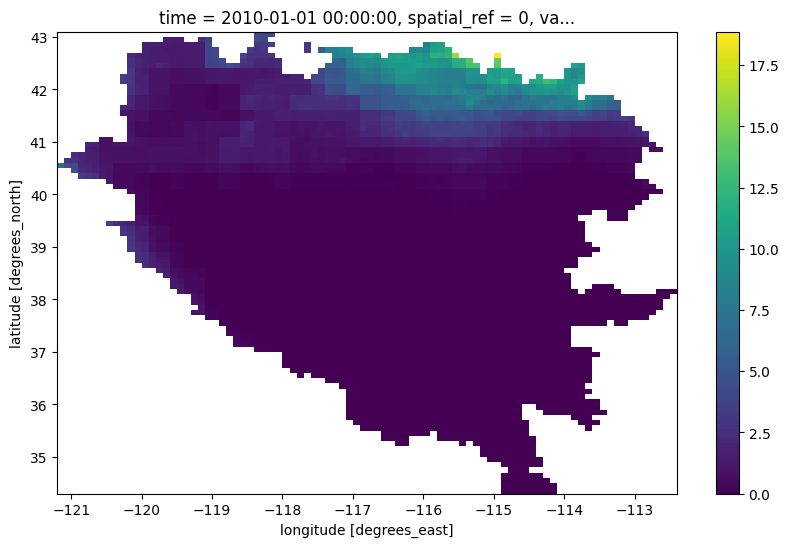

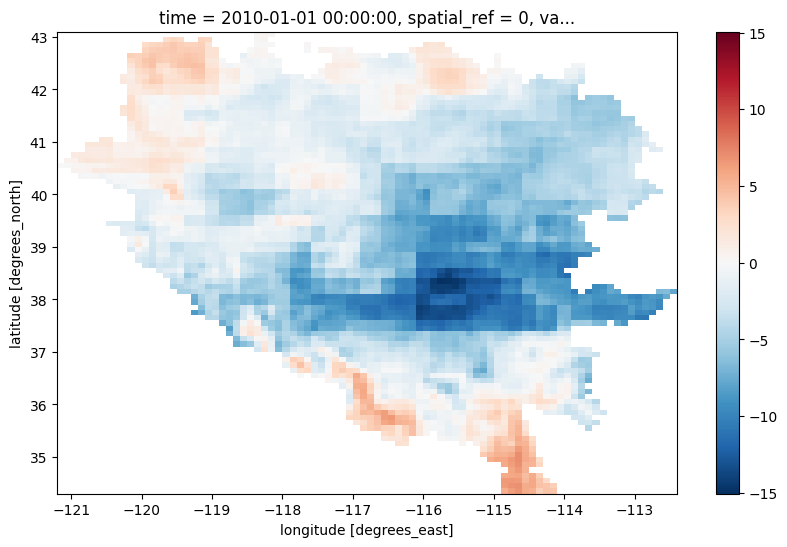

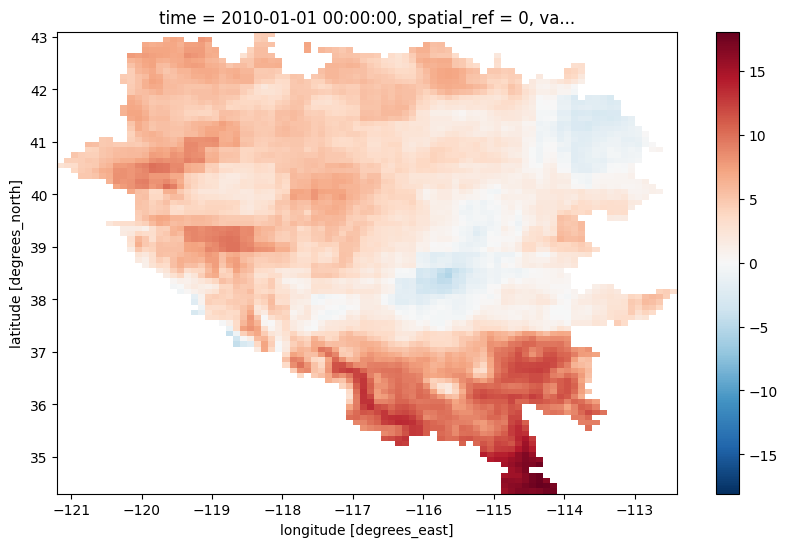

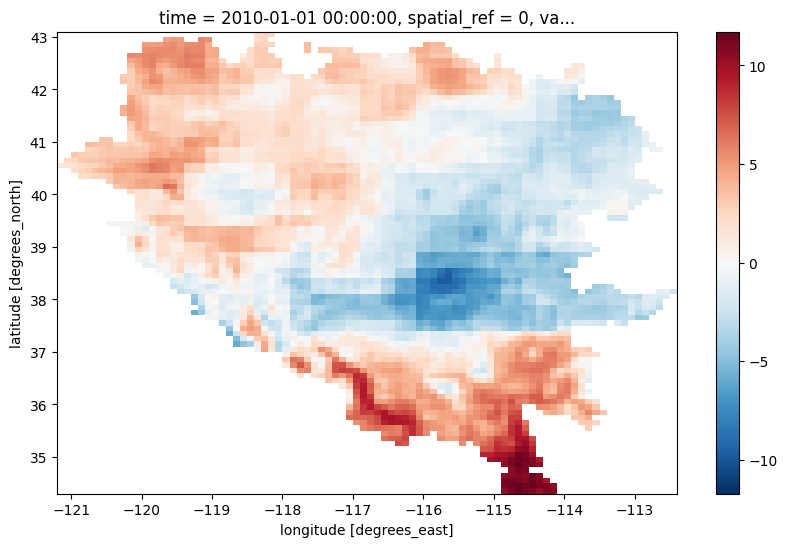

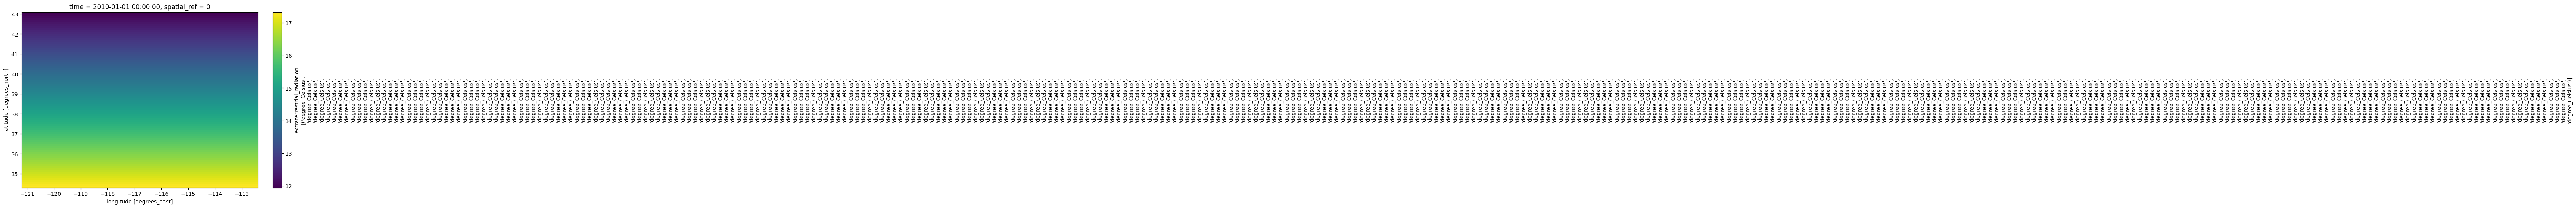

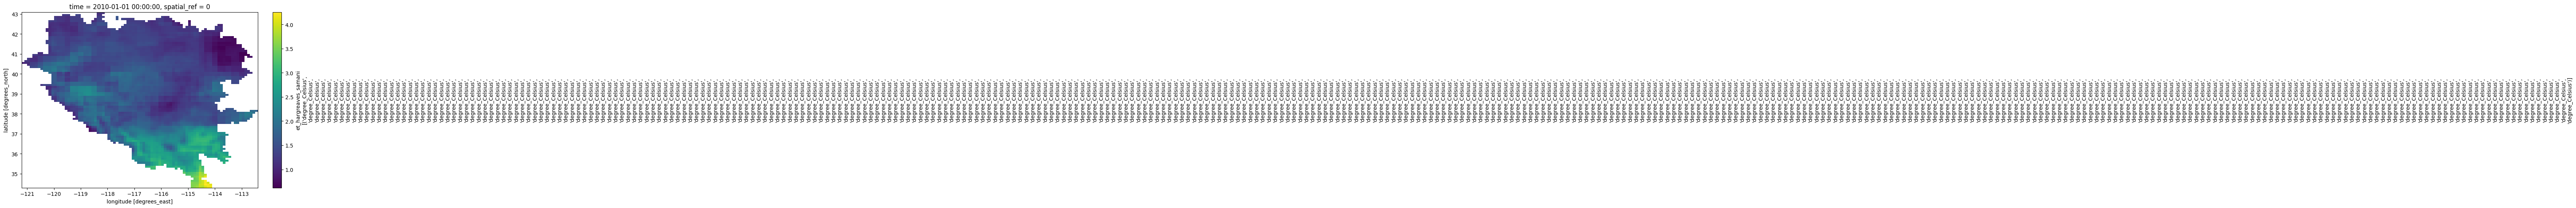

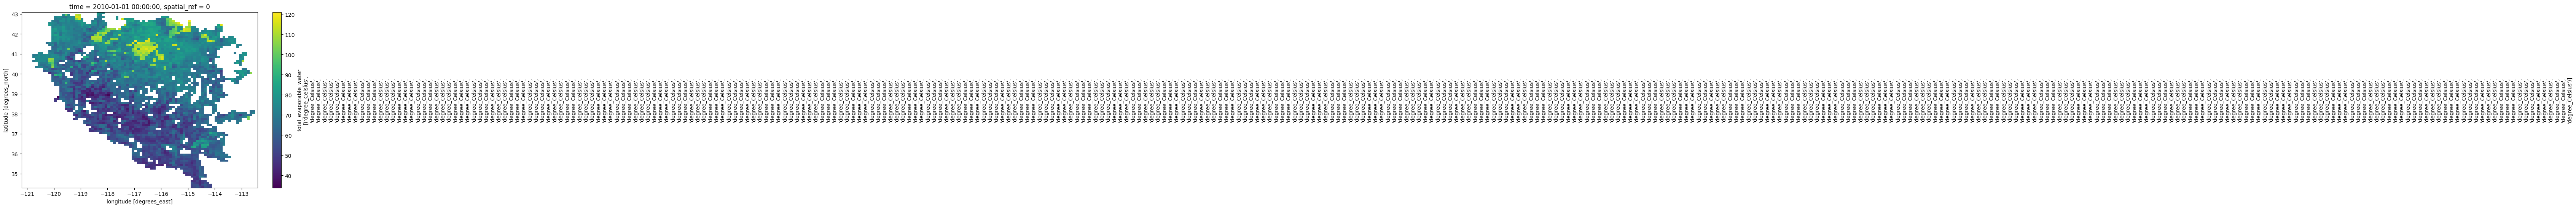

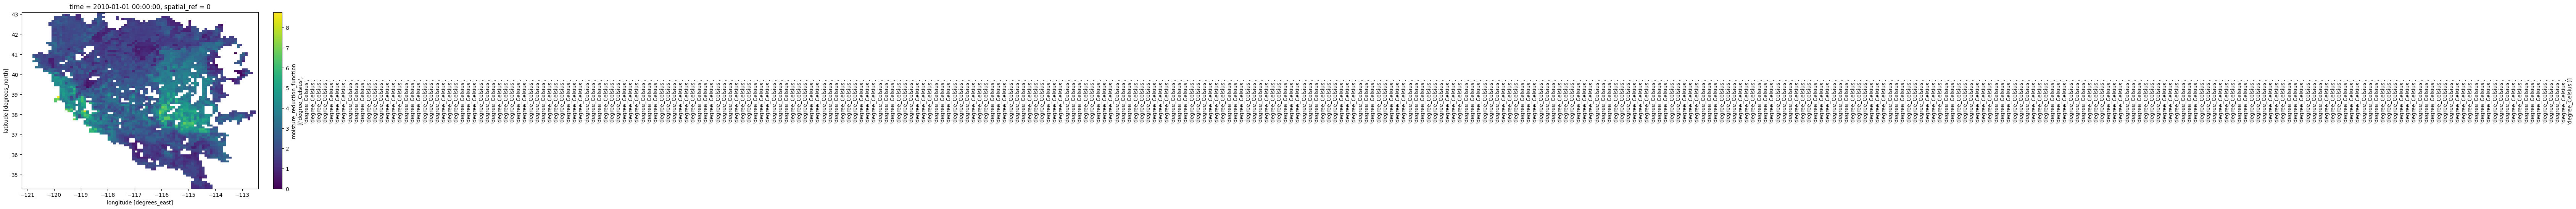

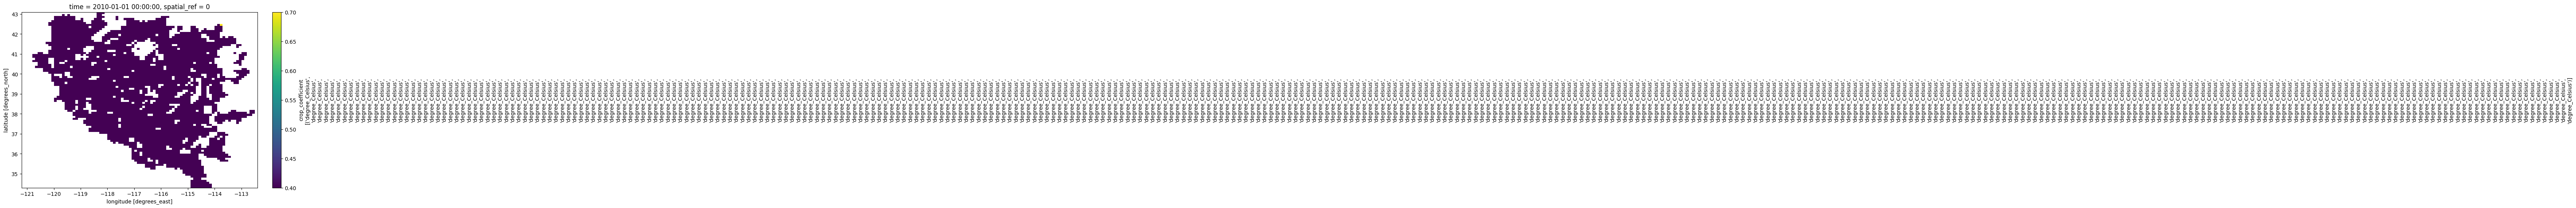

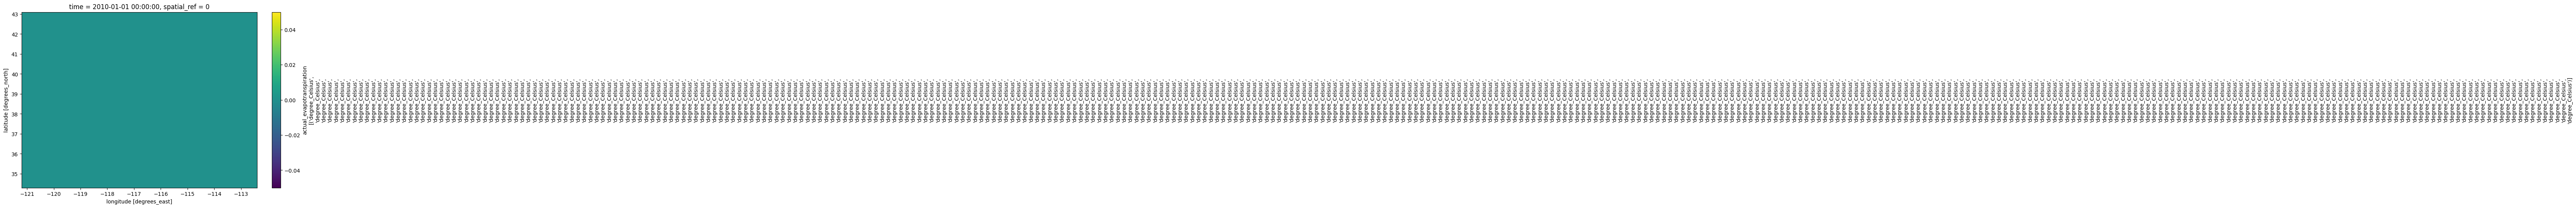

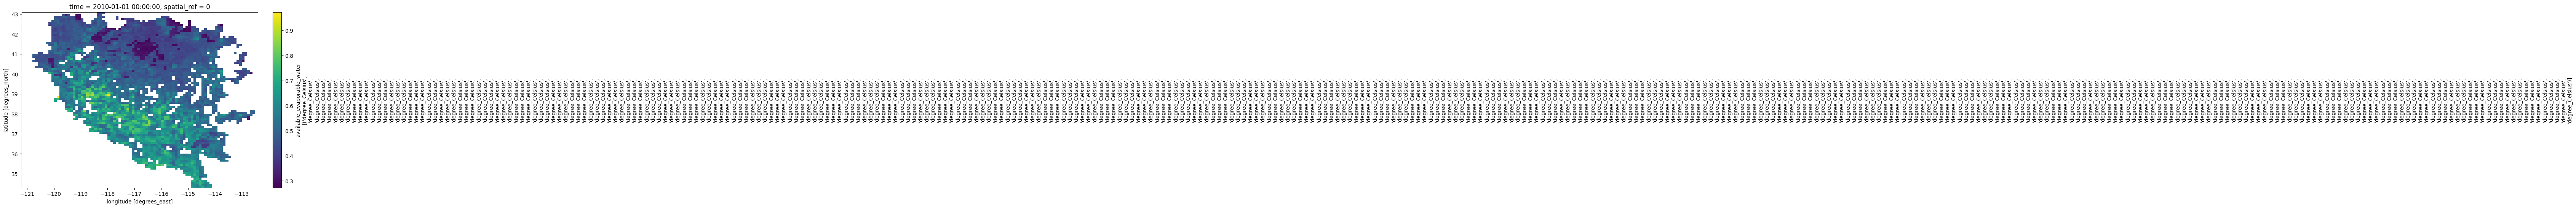

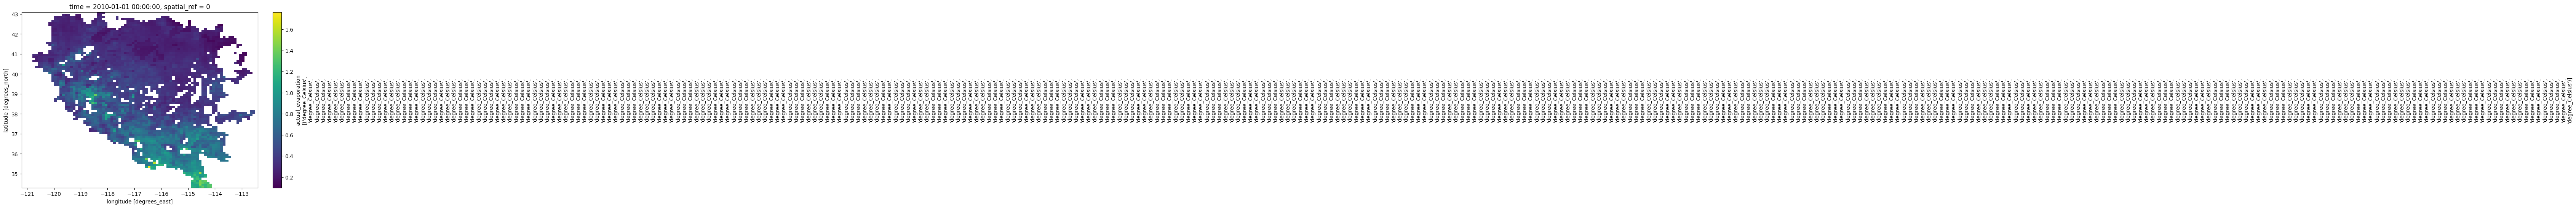

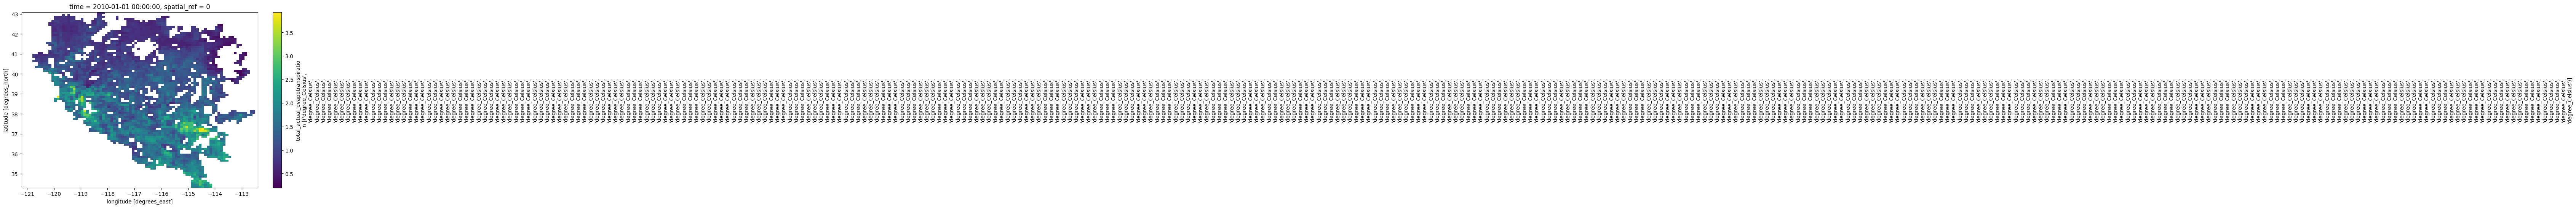

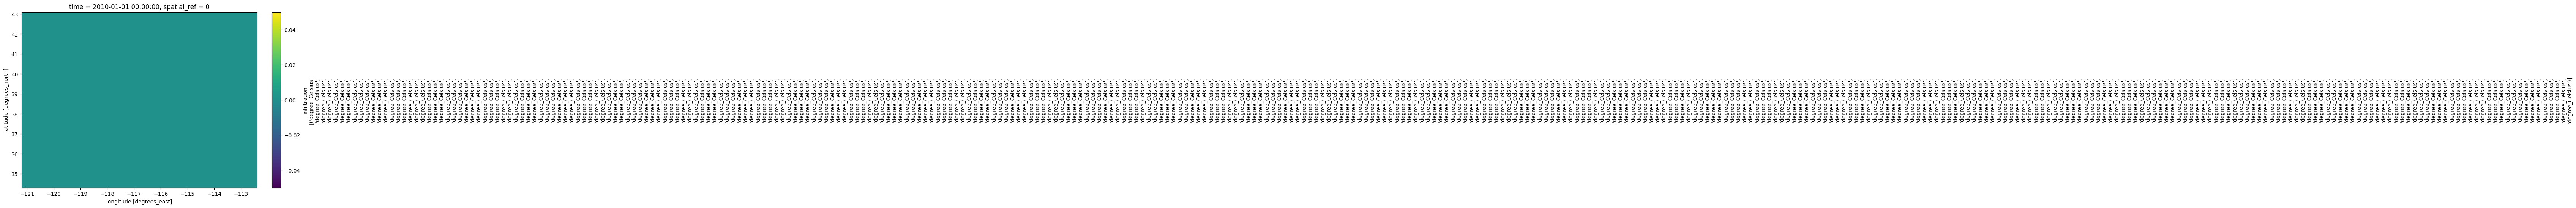

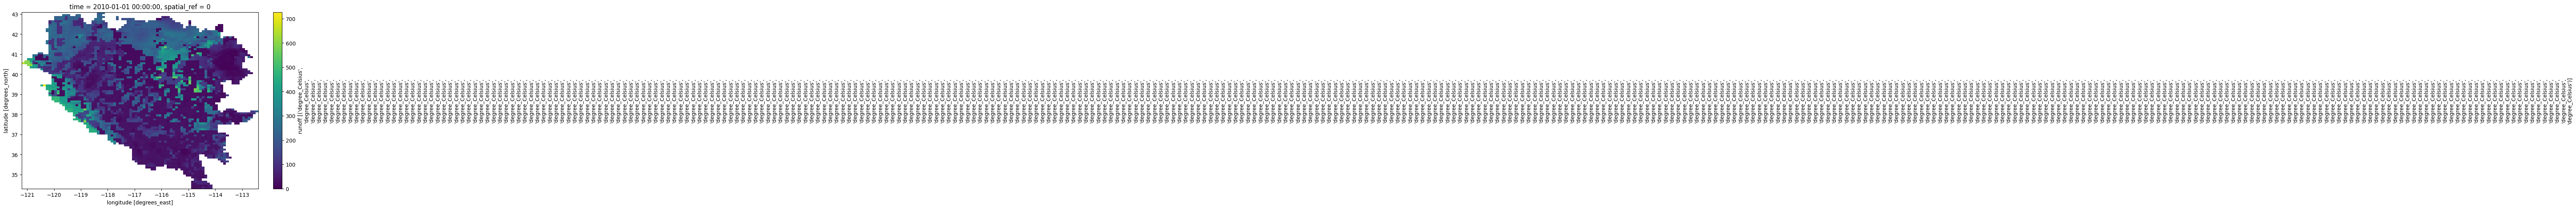

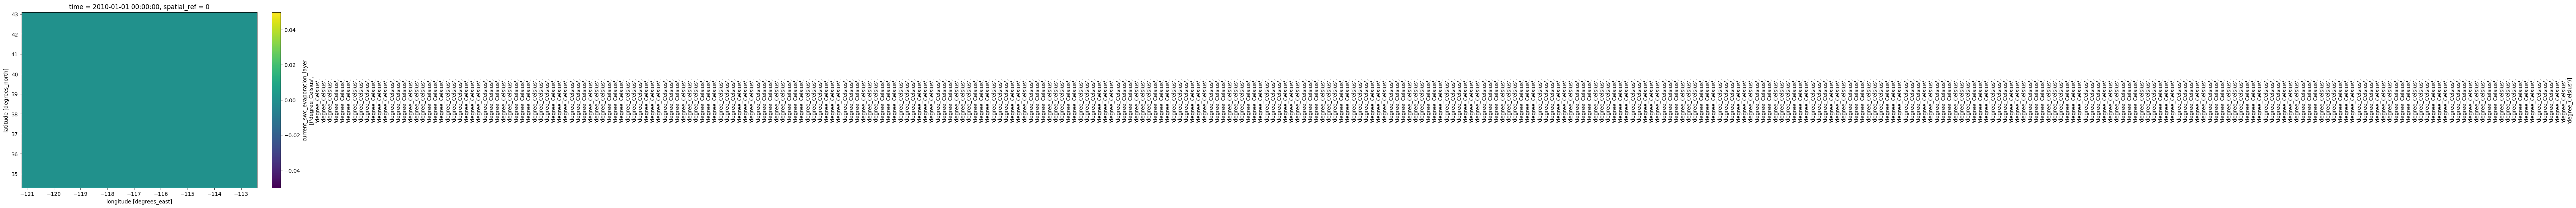

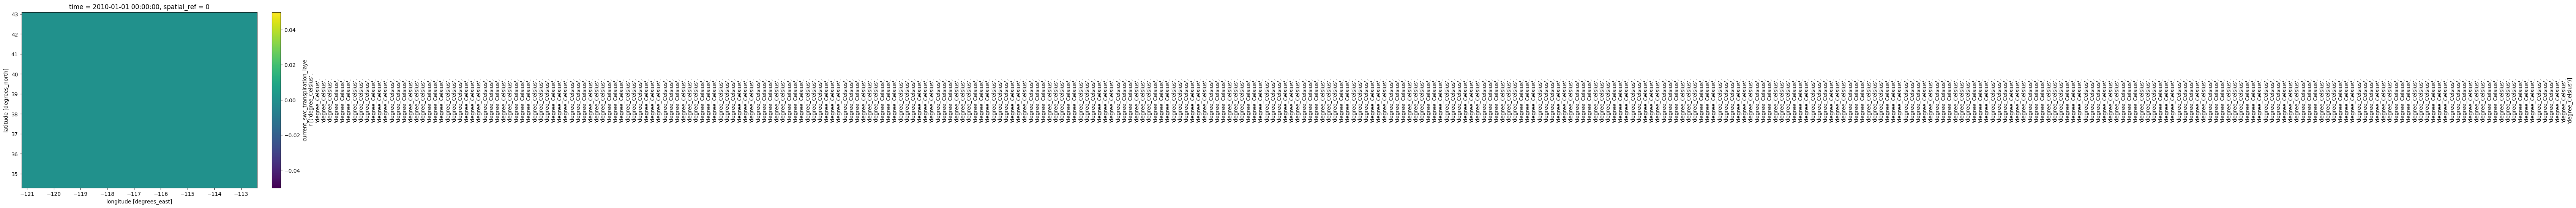

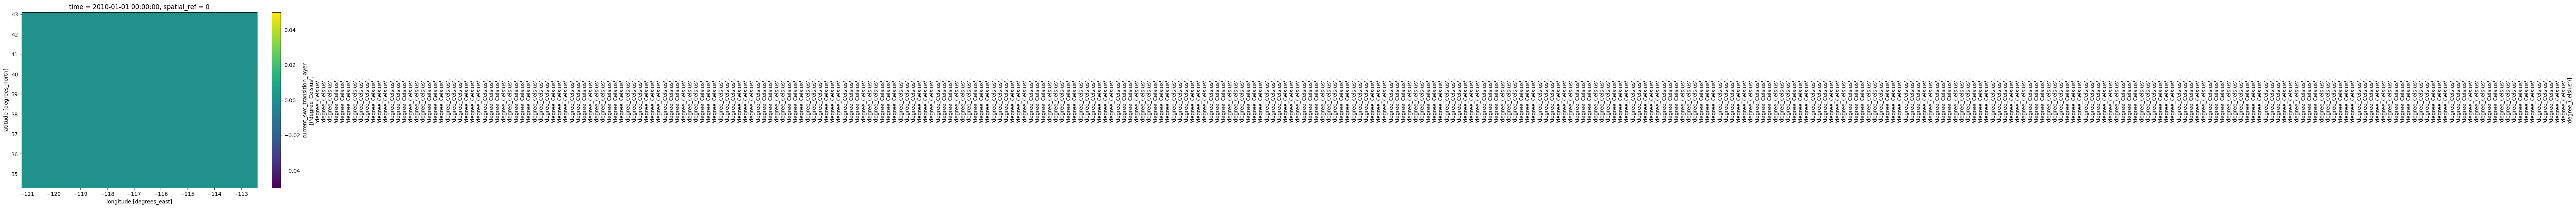

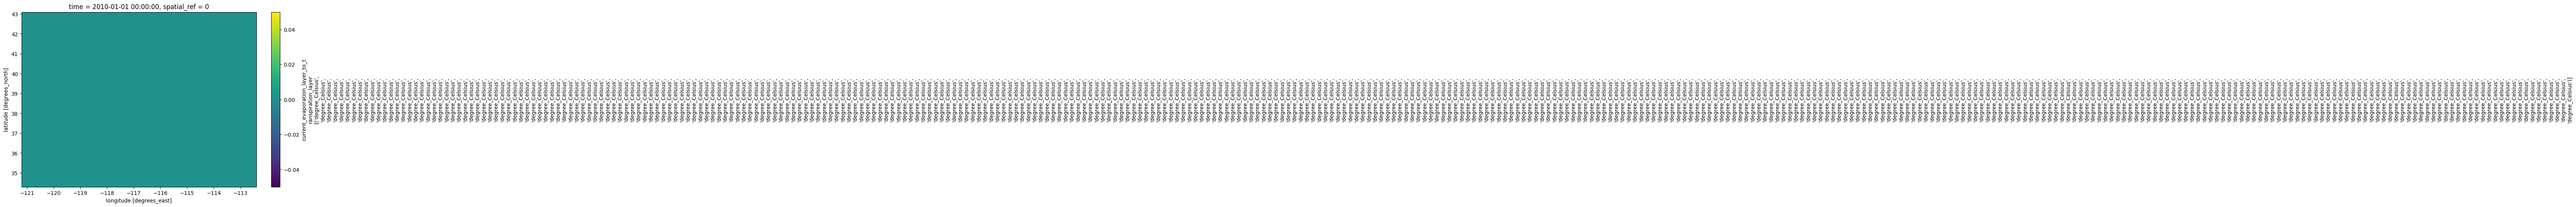

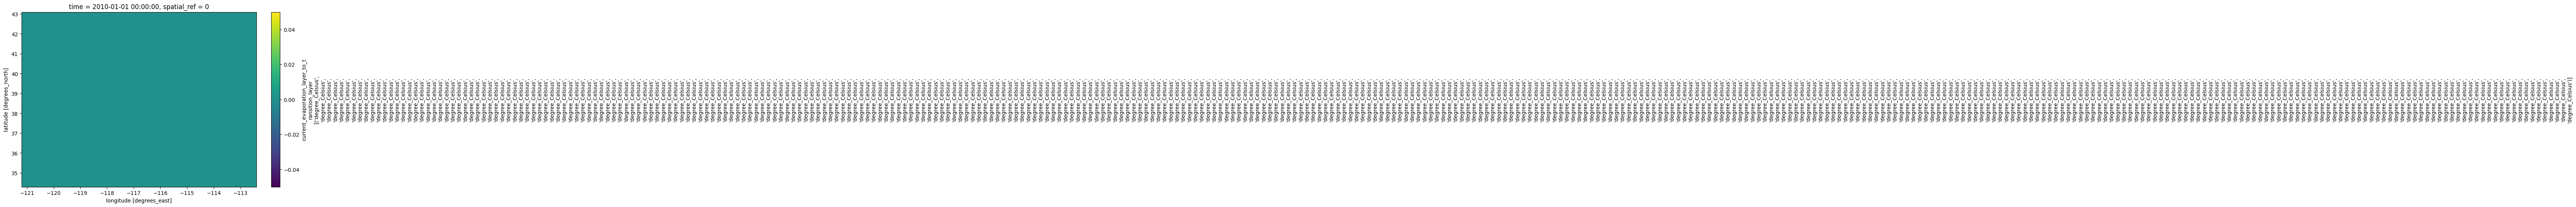

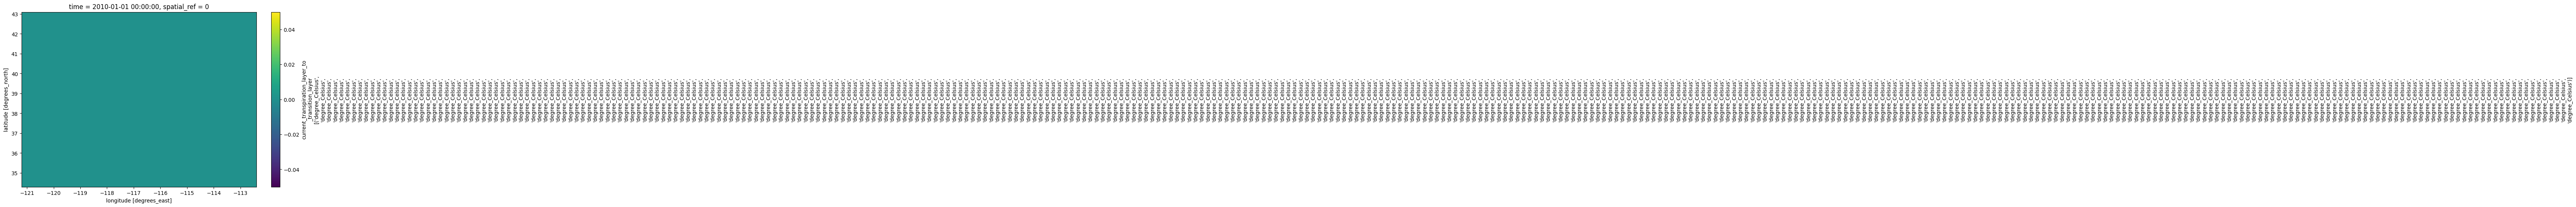

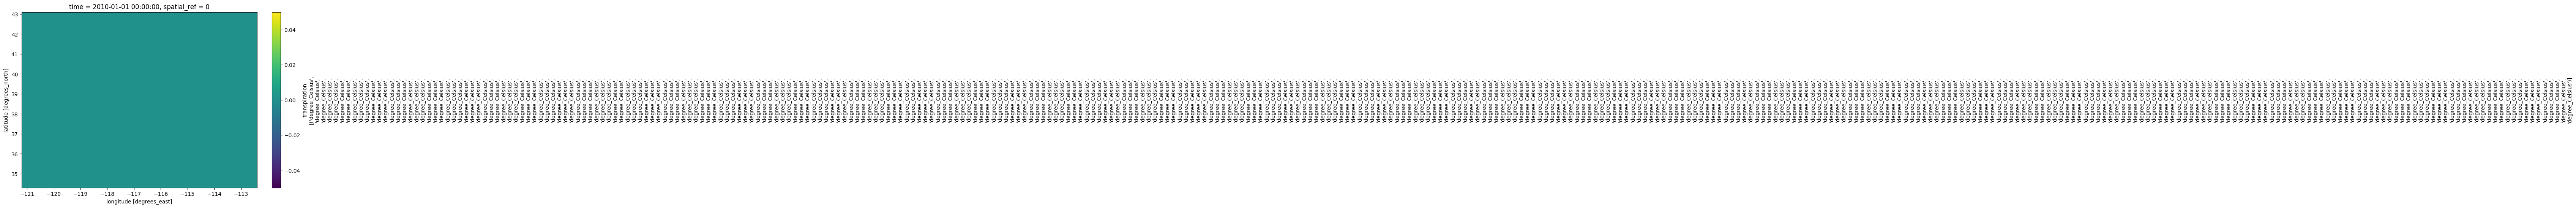

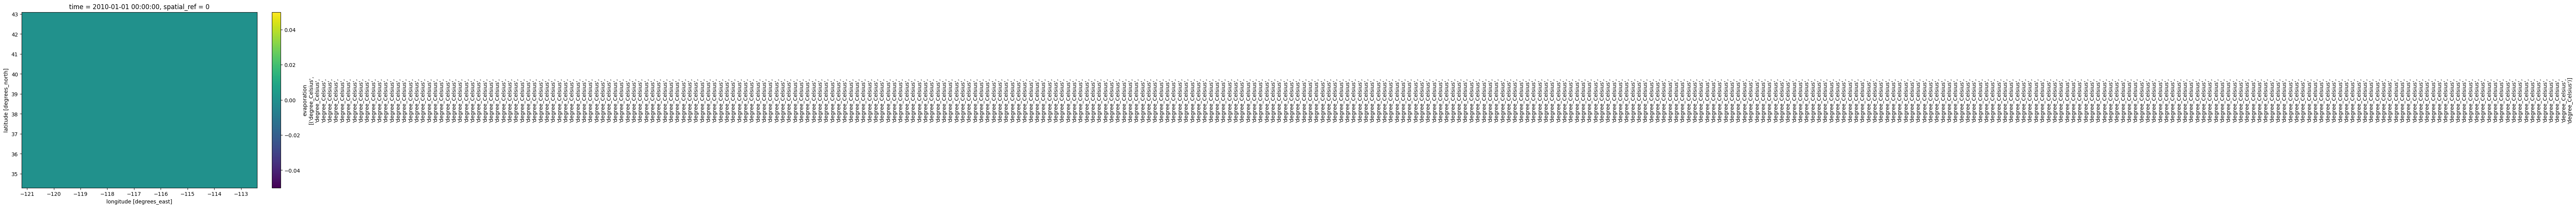

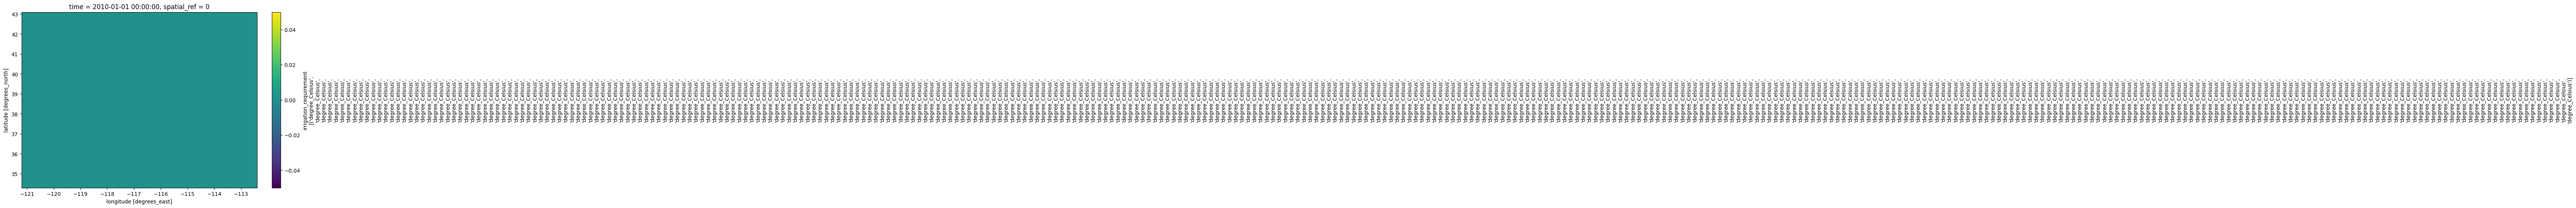

In [26]:
selected_years = [2010, 2011]

path_export_data = "D:\\mehdi\\DailyData\\export\\"

for year in selected_years:
    
    p1 = rioxarray.open_rasterio(f"{data_path}{list_files['P'][list_files['P']['year'] == year]['file'].values[0]}")
    p1 = mask_xarray(array = p1, shapefile_basins = shapefile_basins)
    p1.data = np.where(p1.data == -9.999e+03, np.nan, p1.data)
    p1.name = 'precipitation'
    Pre = p1.to_dataset()
    Pre = Pre.rename({'x': 'lon','y': 'lat'})
    
    
    # Tmin = xr.open_dataset(f"{data_path}{list_files['Tmin'][list_files['Tmin']['year'] == year]['file'].values[0]}")
    t1 = rioxarray.open_rasterio(f"{data_path}{list_files['Tmin'][list_files['Tmin']['year'] == year]['file'].values[0]}")
    t1 = mask_xarray(array = t1, shapefile_basins = shapefile_basins)
    t1.data = np.where(t1.data == -9.99900e+03, np.nan, t1.data)
    t1.name = 'air_temperature'
    Tmin = t1.to_dataset()
    Tmin = Tmin.rename({'x': 'lon','y': 'lat'})
    
    
    t2 = rioxarray.open_rasterio(f"{data_path}{list_files['Tmax'][list_files['Tmax']['year'] == year]['file'].values[0]}")
    t2 = mask_xarray(array = t2, shapefile_basins = shapefile_basins)
    t2.data = np.where(t2.data == -9.99900e+03, np.nan, t2.data)
    t2.name = 'air_temperature'
    Tmax = t2.to_dataset() 
    Tmax = Tmax.rename({'x': 'lon','y': 'lat'})
    
    lat = np.repeat(Tmin.lat, Tmin.lon.size).values.reshape(Tmin.lat.size, Tmin.lon.size)    
    lon = np.repeat(Tmin.lon, Tmin.lat.size).values.reshape(Tmin.lat.size, Tmin.lon.size)
    
    tmpDataArray = Tmin.copy(deep = True)
    tmpDataArray = tmpDataArray.rename({'air_temperature': 'temp'})
    tmpDataArray["temp"].values = np.empty(shape=tmpDataArray["temp"].shape)
        
    Ra = tmpDataArray.copy(deep = True)    
    Ra = Ra.rename({'temp': 'extraterrestrial_radiation'})
    
    ET = tmpDataArray.copy(deep = True)    
    ET = ET.rename({'temp': 'et_hargreaves_samani'})
    
    TE = tmpDataArray.copy(deep = True)    
    TE = TE.rename({'temp': 'total_evaporable_water'})
    
    MRF = tmpDataArray.copy(deep = True)    
    MRF = MRF.rename({'temp': 'moisture_reduction_function'})
    
    f_adjusted = tmpDataArray.copy(deep = True)    
    f_adjusted = f_adjusted.rename({'temp': 'moisture_reduction_function'})
    
    ET_actual = tmpDataArray.copy(deep = True)    
    ET_actual = ET_actual.rename({'temp': 'actual_evapotranspiration'})
    
    K_E = tmpDataArray.copy(deep = True)    
    K_E = K_E.rename({'temp': 'available_evaporable_water'})
    
    E_actual = tmpDataArray.copy(deep = True)    
    E_actual = E_actual.rename({'temp': 'actual_evaporation'})
    
    ET_total_actual = tmpDataArray.copy(deep = True)    
    ET_total_actual = ET_total_actual.rename({'temp': 'total_actual_evapotranspiration'})
    
    RUN_OFF = tmpDataArray.copy(deep = True)    
    RUN_OFF = RUN_OFF.rename({'temp': 'runoff'})
    
    INFILTRATION = tmpDataArray.copy(deep = True)    
    INFILTRATION = INFILTRATION.rename({'temp': 'infiltration'})
    
    CROP_COEFFICIENT = tmpDataArray.copy(deep = True)    
    CROP_COEFFICIENT = CROP_COEFFICIENT.rename({'temp': 'crop_coefficient'})
    
    SWC_EVAPORATION = tmpDataArray.copy(deep = True)    
    SWC_EVAPORATION = SWC_EVAPORATION.rename({'temp': 'current_swc_evaporation_layer'})
    
    SWC_TRANSPIRATION = tmpDataArray.copy(deep = True)    
    SWC_TRANSPIRATION = SWC_TRANSPIRATION.rename({'temp': 'current_swc_transpiration_layer'})
    
    SWC_TRANSITION = tmpDataArray.copy(deep = True)    
    SWC_TRANSITION = SWC_TRANSITION.rename({'temp': 'current_swc_transition_layer'})
    
    EVAPORATION_TO_TRANSPIRATION = tmpDataArray.copy(deep = True)    
    EVAPORATION_TO_TRANSPIRATION = EVAPORATION_TO_TRANSPIRATION.rename({'temp': 'current_evaporation_layer_to_transpiration_layer'})
    
    EVAPORATION_TO_TRANSITION = tmpDataArray.copy(deep = True)    
    EVAPORATION_TO_TRANSITION = EVAPORATION_TO_TRANSITION.rename({'temp': 'current_evaporation_layer_to_transition_layer'})
    
    TRANSPIRATION_TO_TRANSITION = tmpDataArray.copy(deep = True)    
    TRANSPIRATION_TO_TRANSITION = TRANSPIRATION_TO_TRANSITION.rename({'temp': 'current_transpiration_layer_to_transition_layer'})
    
    TRANSPIRATION_ADJUSTED = tmpDataArray.copy(deep = True)    
    TRANSPIRATION_ADJUSTED = TRANSPIRATION_ADJUSTED.rename({'temp': 'transpiration'})
    
    EVAPORATION_ADJUSTED = tmpDataArray.copy(deep = True)    
    EVAPORATION_ADJUSTED = EVAPORATION_ADJUSTED.rename({'temp': 'evaporation'})
    
    IRRIGATION_REQUIREMENT = tmpDataArray.copy(deep = True)    
    IRRIGATION_REQUIREMENT = IRRIGATION_REQUIREMENT.rename({'temp': 'irrigation_requirement'})
    
    DEEP_PERCOLATION = tmpDataArray.copy(deep = True)    
    DEEP_PERCOLATION = DEEP_PERCOLATION.rename({'temp': 'deepPercolation'})
    
    for j_day in range(1, Tmin.time.size + 1):
        
        print(year, j_day)
        
        if year == selected_years[0] and j_day == 1:
            swc = xr.open_dataset("D:\mehdi\DailyData\soil_water_content_1979001.nc")        
            swc = swc.fillna(0)
            
            soil_water_content = mask_xarray(array = swc, shapefile_basins = shapefile_basins)
            soil_water_content = soil_water_content.rename({'x': 'lon','y': 'lat'})
            
            soil_water_content_evaporation = soil_water_content["volumetric_soil_water_layer_1"].sel(time = "1979-01-01")[:, :].data
            soil_water_content_transpiration = soil_water_content["volumetric_soil_water_layer_2"] + soil_water_content["volumetric_soil_water_layer_3"]
            soil_water_content_transpiration = soil_water_content_transpiration.sel(time = "1979-01-01")[:, :].data
            soil_water_content_transition = soil_water_content["volumetric_soil_water_layer_4"].sel(time = "1979-01-01")[:, :].data
            
            
            
            constant_value_for_AE = 33
            # AE = xr.Dataset(
            #     data_vars={
            #         "available_evaporable_water": (("time", "lat", "lon"), np.full((len(soil_water_content.time), len(soil_water_content.lat), len(soil_water_content.lon)), constant_value_for_AE))
            #     },
            #     coords={
            #         "lat": soil_water_content.lat,
            #         "lon": soil_water_content.lon,
            #         "time": soil_water_content.time
            #     },
            # )
            # AE = AE.to_array()
            
            AE = np.zeros((len(soil_water_content.lat), len(soil_water_content.lon))) + constant_value_for_AE
                    
        else:
            
            soil_water_content_evaporation = soil_water_content_day[0][0]
            soil_water_content_evaporation = np.vectorize(lambda d: 0 if np.isnan(d) else d)(
                d = soil_water_content_evaporation
            )
            soil_water_content_transpiration = soil_water_content_day[1][0]
            soil_water_content_transition = soil_water_content_day[2][0]
            
            # TODO: AE???
            AE = np.vectorize(available_evaporable_water)(
                e_a = e_actual_day,
                infiltration = run_off_and_infiltration_day[1],
                available_evaporable_water_in_previous_step = available_evaporable_water_day
            )
            

        
        date_object = datetime.datetime.strptime(f"{year}{j_day}", '%Y%j').date()
        model_date = date_object.strftime("%Y-%m-%d")
        
        pre_day = Pre.to_array()[0, j_day - 1, :, :]
        myPlot(pre_day, "pre", year, j_day)      
        
        Tmin_day = Tmin.to_array()[0, j_day - 1, :, :]
        myPlot(Tmin_day, "Tmin", year, j_day)
        
        Tmax_day = Tmax.to_array()[0, j_day - 1, :, :]
        myPlot(Tmax_day, "Tmax", year, j_day)
        
        Tmean_day = (Tmin_day + Tmax_day) / 2
        myPlot(Tmean_day, "Tmean", year, j_day)
        
        ra_day = np.vectorize(extraterrestrial_radiation)(
            inverse_relative_distance_earth_sun(
                julian_date = j_day
            ),
            sunset_hour_angle(
                latitude=convert_degrees2radians(lat),
                solar_declination = solar_declination(
                    julian_date = j_day
                )
            ),
            convert_degrees2radians(
                degrees = lat
            ),
            solar_declination(
                julian_date = j_day
            )            
        )
        
        
        Ra["extraterrestrial_radiation"][j_day - 1, :, :] = ra_day
        myPlot(Ra["extraterrestrial_radiation"][j_day - 1], "Ra", year, j_day)
                
        et_day_hargreaves_samani = np.vectorize(ReferenceEvapotranspiration.hargreaves_samani)(
            tmin = Tmin_day,
            tmax = Tmax_day,
            tmean = Tmean_day,
            ra = ra_day
        )
        et_day_hargreaves_samani = np.vectorize(lambda d: 0 if d < 0 else d)(
            d = et_day_hargreaves_samani
        )
        
        
        ET["et_hargreaves_samani"][j_day - 1, :, :] = et_day_hargreaves_samani
        myPlot(ET["et_hargreaves_samani"][j_day - 1], "et_day_hargreaves_samani", year, j_day)
        
        total_evaporable_water_day = np.vectorize(available_water)(
            permanent_wilting_point_wet = wp["b0"].sel(time = "1979-01-01")[:, :],
            field_capacity_wet = fc["b0"].sel(time = "1979-01-01")[:, :],
            soil_depth = land_use["Maximum Crop Height (h) (m)"].sel(time = "2022-01-01")[:, :]*1000
        )
        

        
        TE["total_evaporable_water"][j_day - 1, :, :] = total_evaporable_water_day
        myPlot(TE["total_evaporable_water"][j_day - 1], "total_evaporable_water_day", year, j_day)
        
        
        
        f_day = np.vectorize(moisture_reduction_function)(
            soil_wetness_in_previous_step = soil_water_content_transpiration,
            permanent_wilting_point_wet = wp["b0"].sel(time = "1979-01-01")[:, :],
            field_capacity_wet = fc["b0"].sel(time = "1979-01-01")[:, :],
            soil_depth = land_use["Maximum Crop Height (h) (m)"].sel(time = "2022-01-01")[:, :]*1000
        )
        
        # FIXME: soil_water_content_transpiration 
        
        MRF["moisture_reduction_function"][j_day - 1, :, :] = f_day
        
        f_adjusted_day = np.vectorize(lambda d: 0 if d < 0 else d)(
            d = f_day
        )
        
        
        f_adjusted["moisture_reduction_function"][j_day - 1, :, :] = f_adjusted_day
        myPlot(f_adjusted["moisture_reduction_function"][j_day - 1], "f_adjusted_day", year, j_day)
        
        plant_date_day = np.vectorize(generate_date)(
            x = land_use['Plant Date'].sel(time = "2022-01-01")[:,:],
            year = year
        )
        plant_date_day = np.where(plant_date_day == "nan", pd.NA, plant_date_day)        
        # plant_date_day = np.where(pd.isnull(plant_date_day), np.nan, plant_date_day)
        plant_date_day = np.where(pd.isnull(plant_date_day), "1960-01-01", plant_date_day)
        
        crop_coefficient_day = np.vectorize(PotentialEvapotranspiration.calculate_single_crop_coefficient_for_linear_changes_steps)(
            crop_coefficient_ini = land_use["Kc init"].sel(time = "2022-01-01")[:,:],
            crop_coefficient_mid = land_use["Kc mid"].sel(time = "2022-01-01")[:,:],
            crop_coefficient_end = land_use["Kc end"].sel(time = "2022-01-01")[:,:],
            length_ini_crop = land_use["Init. (Lini)"].sel(time = "2022-01-01")[:,:],
            length_dev_crop = land_use["Dev. (Ldev)"].sel(time = "2022-01-01")[:,:],
            length_mid_crop = land_use["Mid (Lmid)"].sel(time = "2022-01-01")[:,:],
            length_late_crop = land_use["Late (Llate)"].sel(time = "2022-01-01")[:,:],
            plant_date = plant_date_day[:,:],
            modeling_date = model_date
        )
        
        CROP_COEFFICIENT["crop_coefficient"][j_day - 1, :, :] = crop_coefficient_day
        myPlot(CROP_COEFFICIENT["crop_coefficient"][j_day - 1], "crop_coefficient_day", year, j_day)
        
         
        et_actual_day = np.vectorize(ActualEvapotranspiration.et_covered)(
            moisture_reduction_function = f_adjusted_day,
            crop_coefficient = CROP_COEFFICIENT["crop_coefficient"].sel(time = model_date)[:,:],
            crop_cover = lu["crop cover"].sel(time = "2022-01-01"),
            reference_crop_evapotranspiration = et_day_hargreaves_samani
        )
        

        ET_actual["actual_evapotranspiration"][j_day - 1, :, :].data = et_actual_day[0]
        myPlot(ET_actual["actual_evapotranspiration"][j_day - 1], "et_actual_day", year, j_day)
        
        available_evaporable_water_day = AE
        # available_evaporable_water_day = AE[:, :]
        
        k_e_day = np.vectorize(ratio_of_actual_evaporable_water_to_total_evaporable_water)(
            available_water = total_evaporable_water_day,
            available_evaporable_water = available_evaporable_water_day
        )
        
        K_E["available_evaporable_water"][j_day - 1, :, :] = k_e_day
        myPlot(K_E["available_evaporable_water"][j_day - 1], "k_e_day", year, j_day)
        
        
        e_actual_day = np.vectorize(ActualEvapotranspiration.e_noncovered)(
            ratio_of_actual_evaporable_water_to_total_evaporable_water = k_e_day,
            crop_cover = lu["crop cover"].sel(time = "2022-01-01"),
            reference_crop_evapotranspiration = et_day_hargreaves_samani
        )
        
        
        E_actual["actual_evaporation"][j_day - 1, :, :] = e_actual_day
        myPlot(E_actual["actual_evaporation"][j_day - 1], "e_actual_day", year, j_day)
        
        et_total_actual_day = np.vectorize(ActualEvapotranspiration.et_QDWB)(
            evaporation_noncovered_areas = e_actual_day,
            evapotranspiration_covered_areas = et_actual_day
        )
        
        
        ET_total_actual["total_actual_evapotranspiration"][j_day - 1, :, :] = et_total_actual_day[0]
        myPlot(ET_total_actual["total_actual_evapotranspiration"][j_day - 1], "et_total_actual_day", year, j_day)
        
        model_date_array = np.array([datetime.datetime.strptime(model_date, '%Y-%m-%d')] * plant_date_day.shape[0] * plant_date_day.shape[1]).reshape(plant_date_day.shape[0], plant_date_day.shape[1])
        plant_date_day_array = np.vectorize(lambda d: datetime.datetime.strptime(d, '%Y-%m-%d'))(
            d = plant_date_day
        )
        total_adjusted = np.where(np.isnan(land_use["Total"][0].data), 0 , land_use["Total"][0].data)
        
        end_date_of_growing = np.vectorize(lambda x , y: x + datetime.timedelta(days=y))(
            x = plant_date_day_array,
            y = total_adjusted
        )
        growing_season = np.vectorize(lambda m, a, b: True if m >= a and m <= b else False)(
            m = model_date_array,
            a = plant_date_day_array,
            b = end_date_of_growing
        )
        
        # ### run off
        
        run_off_and_infiltration_day = np.vectorize(PrimarySurfaceFlow.scs)(
            precipitation = pre_day,
            curve_number = cn["dry"].sel(time = "1979-01-01")[:, :],
            rsa = True,
            antecedent_precipitation = soil_water_content_evaporation,
            is_growing_season = growing_season
        )
        infiltration_day = run_off_and_infiltration_day[1]
        run_off_day = run_off_and_infiltration_day[0] + (infiltration_day * (1 - lu["inf"].sel(time = "2022-01-01")))
        infiltration_day = infiltration_day * lu["inf"].sel(time = "2022-01-01")
        
        INFILTRATION["infiltration"][j_day - 1, :, :].data = infiltration_day.data
        myPlot(INFILTRATION["infiltration"][j_day - 1], "infiltration_day", year, j_day)
        
        # ### soil water content

        
        soil_water_content_day = np.vectorize(waterSoilContent)(
            covered = land_use["cultivated"].sel(time = "2022-01-01")[:,:],
            infiltration= infiltration_day,
            evaporation= e_actual_day,
            init_swc_evaporation_layer = soil_water_content_evaporation,
            init_swc_transition_layer = soil_water_content_transition,
            z_evaporation_layer = 100,
            z_transition_layer = 1000,
            fc_evaporation_layer = fc["b10"].sel(time = "1979-01-01")[:, :],
            fc_transition_layer = fc["b200"].sel(time = "1979-01-01")[:, :],
            pwp_evaporation_layer = wp["b10"].sel(time = "1979-01-01")[:, :],
            pwp_transition_layer = wp["b200"].sel(time = "1979-01-01")[:, :],
            stress_coefficient = 0.7,
            MAD = 0.3,
            transpiration = et_actual_day,
            init_swc_transpiration_layer = soil_water_content_transpiration,
            pwp_transpiration_layer = wp["b100"].sel(time = "1979-01-01")[:, :],
            z_transpiration_layer = land_use["Maximum Crop Height (h) (m)"].sel(time = "2022-01-01")[:, :]*1000,
            fc_transpiration_layer = fc["b100"].sel(time = "1979-01-01")[:, :]
        )
        
        deep_percolation_day = soil_water_content_day[9]
        run_off_day = run_off_day.data + (deep_percolation_day[0] * (1 - lithology["GP"].sel(time = "2022-01-01").data))
        deep_percolation_day = deep_percolation_day[0] * lithology["GP"].sel(time = "2022-01-01").data
        
        RUN_OFF["runoff"][j_day - 1, :, :] = run_off_day        
        SWC_EVAPORATION["current_swc_evaporation_layer"][j_day - 1, :, :].data = soil_water_content_day[0][0]
        SWC_TRANSPIRATION["current_swc_transpiration_layer"][j_day - 1, :, :].data = soil_water_content_day[1][0]
        SWC_TRANSITION["current_swc_transition_layer"][j_day - 1, :, :].data = soil_water_content_day[2][0]
        EVAPORATION_TO_TRANSPIRATION["current_evaporation_layer_to_transpiration_layer"][j_day - 1, :, :].data = soil_water_content_day[3][0]
        EVAPORATION_TO_TRANSITION["current_evaporation_layer_to_transition_layer"][j_day - 1, :, :].data = soil_water_content_day[4][0]
        TRANSPIRATION_TO_TRANSITION["current_transpiration_layer_to_transition_layer"][j_day - 1, :, :].data = soil_water_content_day[5][0]
        TRANSPIRATION_ADJUSTED["transpiration"][j_day - 1, :, :].data = soil_water_content_day[6][0]
        EVAPORATION_ADJUSTED["evaporation"][j_day - 1, :, :].data = soil_water_content_day[7][0]
        IRRIGATION_REQUIREMENT["irrigation_requirement"][j_day - 1, :, :].data = soil_water_content_day[8][0]
        DEEP_PERCOLATION["deepPercolation"][j_day - 1, :, :].data = deep_percolation_day
        
        myPlot(RUN_OFF["runoff"][j_day - 1], "RUN_OFF", year, j_day)
        myPlot(SWC_EVAPORATION["current_swc_evaporation_layer"][j_day - 1], "SWC_EVAPORATION", year, j_day)
        myPlot(SWC_TRANSPIRATION["current_swc_transpiration_layer"][j_day - 1], "SWC_TRANSPIRATION", year, j_day)
        myPlot(SWC_TRANSITION["current_swc_transition_layer"][j_day - 1], "SWC_TRANSITION", year, j_day)
        myPlot(EVAPORATION_TO_TRANSPIRATION["current_evaporation_layer_to_transpiration_layer"][j_day - 1], "EVAPORATION_TO_TRANSPIRATION", year, j_day)
        myPlot(EVAPORATION_TO_TRANSITION["current_evaporation_layer_to_transition_layer"][j_day - 1], "EVAPORATION_TO_TRANSITION", year, j_day)
        myPlot(TRANSPIRATION_TO_TRANSITION["current_transpiration_layer_to_transition_layer"][j_day - 1], "TRANSPIRATION_TO_TRANSITION", year, j_day)
        myPlot(TRANSPIRATION_ADJUSTED["transpiration"][j_day - 1], "TRANSPIRATION_ADJUSTED", year, j_day)
        myPlot(EVAPORATION_ADJUSTED["evaporation"][j_day - 1], "EVAPORATION_ADJUSTED", year, j_day)
        myPlot(IRRIGATION_REQUIREMENT["irrigation_requirement"][j_day - 1], "IRRIGATION_REQUIREMENT", year, j_day)
        myPlot(DEEP_PERCOLATION["deepPercolation"][j_day - 1], "DEEP_PERCOLATION", year, j_day)
    
        
        
        # break
    # Ra.to_netcdf(f"{data_path}Ra_{year}.nc")
    
    # ET.to_netcdf(f"{data_path}ET_{year}.nc")
        
    
    

    
    
    # ET.to_netcdf(f"{path_export_data}ET_{year}.nc")
    # CROP_COEFFICIENT.to_netcdf(f"{path_export_data}CROP_COEFFICIENT_{year}.nc")
    # ET_actual.to_netcdf(f"{path_export_data}ET_actual_{year}.nc")
    # K_E.to_netcdf(f"{path_export_data}EK_E_{year}.nc")
    # E_actual.to_netcdf(f"{path_export_data}E_actual_{year}.nc")
    # ET_total_actual.to_netcdf(f"{path_export_data}ET_total_actual_{year}.nc")
    # INFILTRATION.to_netcdf(f"{path_export_data}INFILTRATION_{year}.nc")
    # RUN_OFF.to_netcdf(f"{path_export_data}RUN_OFF_{year}.nc")
    # SWC_EVAPORATION.to_netcdf(f"{path_export_data}SWC_EVAPORATION_{year}.nc")
    # SWC_TRANSPIRATION.to_netcdf(f"{path_export_data}SWC_TRANSPIRATION_{year}.nc")
    # SWC_TRANSITION.to_netcdf(f"{path_export_data}SWC_TRANSITION_{year}.nc")
    # EVAPORATION_TO_TRANSPIRATION.to_netcdf(f"{path_export_data}EVAPORATION_TO_TRANSPIRATION_{year}.nc")
    # EVAPORATION_TO_TRANSITION.to_netcdf(f"{path_export_data}EVAPORATION_TO_TRANSITION_{year}.nc")
    # TRANSPIRATION_TO_TRANSITION.to_netcdf(f"{path_export_data}TRANSPIRATION_TO_TRANSITION_{year}.nc")
    # TRANSPIRATION_ADJUSTED.to_netcdf(f"{path_export_data}TRANSPIRATION_ADJUSTED_{year}.nc")
    # EVAPORATION_ADJUSTED.to_netcdf(f"{path_export_data}EVAPORATION_ADJUSTED_{year}.nc")
    # IRRIGATION_REQUIREMENT.to_netcdf(f"{path_export_data}IRRIGATION_REQUIREMENT_{year}.nc")
    # DEEP_PERCOLATION.to_netcdf(f"{path_export_data}DEEP_PERCOLATION_{year}.nc")
    
    break



